# 프로젝트: 퍼스널 컬러 진단 - KNN

## 데이터
1. Cifer10 동물데이터: http://www.cs.toronto.edu/~kriz/cifar.html  
2. 직접 수집한 쿨톤 100장, 웜톤 100장  

## 목표
1. 우선 CS231에 나온 내용을 기반으로 cifer10 데이터셋을 KNN으로 분류하는 작업을 해보도록 하겠다!
2. 1단계를 적용하여 우리의 퍼스널컬러 데이터를 KNN으로 분류하는 작업을 해보자!
3. KNN + Skin Detection
4. KNN + Face Cropped
5. KNN + gradio

# 1. Cifer10 분류

## (1) 라이브러리 및 데이터 풀러오기

In [ ]:
import tensorflow as tf
import numpy as np

In [ ]:
# CIFAR-10 데이터셋 로드
(Xtr, Ytr), (Xte, Yte) = tf.keras.datasets.cifar10.load_data()

# 데이터 확인
print(Xtr.shape)  # (50000, 32, 32, 3)
print(Ytr.shape)  # (50000, 1)
print(Xte.shape)   # (10000, 32, 32, 3)
print(Yte.shape)   # (10000, 1)

170498071/170498071 [==============================] - 2s 0us/step
(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [ ]:
#print(Xtr)

In [ ]:
print(Ytr)

[[6]
 [9]
 [9]
 ...
 [9]
 [1]
 [1]]


## (2) 데이터 전처리

In [ ]:
# 모든 이미지가 1차원 배열로 저장된다.
Xtr_rows = Xtr.reshape(Xtr.shape[0], 32 * 32 * 3) # Xtr_rows는 50000 x 3072 크기의 배열.
Xte_rows = Xte.reshape(Xte.shape[0], 32 * 32 * 3) # Xte_rows는 10000 x 3072 크기의 배열.

## (3) train, validation 분류하기

In [ ]:
# Xtr_rows, Ytr, Xte_rows, Yte 는 이전과 동일하게 갖고 있다고 가정하자.
# Xtr_rows 는 50,000 x 3072 행렬이었다.
Xval_rows = Xtr_rows[:1000, :] # 앞의 1000 개를 검증용으로 선택한다.
Yval = Ytr[:1000]
Xtr_rows = Xtr_rows[1000:, :] # 뒤쪽의 49,000 개를 학습용으로 선택한다.
Ytr = Ytr[1000:]

## (4) KNN(최접근이웃)

In [ ]:
class NearestNeighbor(object):
    def __init__(self):
        pass

    def train(self, X, y):
        """ X is N x D where each row is an example. Y is 1-dimension of size N """
        # nearest neighbor 분류기는 단순히 모든 학습 데이터를 기억해둔다.
        self.Xtr = X
        self.ytr = y

    def predict(self, X, k):
        """ X is N x D where each row is an example we wish to predict label for """
        num_test = X.shape[0]
        # 출력 type과 입력 type이 갖게 되도록 확인해준다.
        Ypred = np.zeros(num_test, dtype = self.ytr.dtype)

    # loop over all test rows
        for i in range(num_test):
        # i번째 테스트 이미지와 가장 가까운 학습 이미지를
        # L1 거리(절대값 차의 총합)를 이용하여 찾는다.
            distances = np.sum(np.abs(self.Xtr - X[i,:]), axis = 1)
            #distances = np.sqrt(np.sum(np.square(self.Xtr - X[i,:]), axis = 1))
            #min_index = np.argmin(distances) # 가장 작은 distance를 갖는 인덱스를 찾는다.
            #pred[i] = self.ytr[min_index] # 가장 가까운 이웃의 라벨로 예측

            indices = np.argsort(distances)  # 거리가 작은 순서대로 인덱스 정렬
            k_nearest_labels = self.ytr[indices[:k]]  # k개의 가장 가까운 이웃의 라벨
            unique, counts = np.unique(k_nearest_labels, return_counts=True)
            Ypred[i] = unique[np.argmax(counts)]  # 가장 많은 투표를 받은 라벨로 예측
        return Ypred

In [ ]:
# 검증 셋에서 가장 잘 동작하는 hyperparameter 들을 찾는다.
validation_accuracies = []
for k in [1, 3, 5, 10, 20, 50, 100]:

    # 특정 k 값을 정해서 검증 데이터에 대해 평가할 때 사용한다.
    nn = NearestNeighbor()
    nn.train(Xtr_rows, Ytr)
    # 여기서는 k를 input으로 받을 수 있도록 변형된 NearestNeighbor 클래스가 있다고 가정하자.
    Yval_predict = nn.predict(Xval_rows, k = k)
    acc = np.mean(Yval_predict == Yval)
    print('accuracy: %f' % (acc,))

    # 검증 셋에 대한 정확도를 저장해 놓는다.
    validation_accuracies.append((k, acc))

accuracy: 0.099237
accuracy: 0.099692
accuracy: 0.099476
accuracy: 0.099453
accuracy: 0.099738
accuracy: 0.099670
accuracy: 0.099609


In [ ]:
print(validation_accuracies)

[(1, 0.099237), (3, 0.099692), (5, 0.099476), (10, 0.099453), (20, 0.099738), (50, 0.09967), (100, 0.099609)]


-> 데이터 갯수에 비해 k값을 너무 작게 설정한 것 같아서 다시 수정해서 시도

In [ ]:
# 검증 셋에서 가장 잘 동작하는 hyperparameter 들을 찾는다.
validation_accuracies = []
for k in [100, 500, 2000, 4000, 8000]:

    # 특정 k 값을 정해서 검증 데이터에 대해 평가할 때 사용한다.
    nn = NearestNeighbor()
    nn.train(Xtr_rows, Ytr)
    # 여기서는 k를 input으로 받을 수 있도록 변형된 NearestNeighbor 클래스가 있다고 가정하자.
    Yval_predict = nn.predict(Xval_rows, k = k)
    acc = np.mean(Yval_predict == Yval)
    print('accuracy: %f' % (acc,))

    # 검증 셋에 대한 정확도를 저장해 놓는다.
    validation_accuracies.append((k, acc))

accuracy: 0.099609
accuracy: 0.100084
accuracy: 0.100414
accuracy: 0.100554
accuracy: 0.100498


In [ ]:
print(validation_accuracies)

[(100, 0.099609), (500, 0.100084), (2000, 0.100414), (4000, 0.100554), (8000, 0.100498)]


# 2. 퍼스널 컬러 분류: 베이스코드


## (1) 라이브러리 및 데이터 불러오기

In [33]:
import tensorflow as tf
import numpy as np
import cv2
import os
import glob
from PIL import Image

In [34]:
# 파일 불러오는 함수
def load_images_from_directory(directory_path):
    image_paths = glob.glob(directory_path + '/*.jpg')  # 디렉토리 내의 모든 jpg 파일 경로 찾기
    image_paths.extend(glob.glob(directory_path + '/*.jpeg'))  # 디렉토리 내의 모든 jpeg 파일 경로 추가

    images = []
    for image_path in image_paths:
        image = Image.open(image_path)
        image_np = np.array(image)
        images.append(image_np)

    return images

- png파일의 경우 jpg, jfif, jepg 파일과 다른 알고리즘을 사용하여 shape이 동일하지 않는 오류가 뜨는 문제가 있었음. 그래서 모든 파일을 jpg, jepg로 바꾸어 해결함

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
# 모든 이미지 불러오기
directory_path = "/content/drive/MyDrive/four_seasons/사계절_연예인 이미지 데이터셋/prototype/쿨톤_jpg"  # 디렉토리 경로
directory_path2 = "/content/drive/MyDrive/four_seasons/사계절_연예인 이미지 데이터셋/prototype/웜톤_jpg"  # 디렉토리 경로
images = load_images_from_directory(directory_path)
images2 = load_images_from_directory(directory_path2)

length = len(images)
print(length)
print(len(images2))

# 이미지 리스트 합치기
images = np.concatenate((images, images2), axis=0)
print(len(images))

50
50
100


<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


## (2) 데이터 전처리

In [37]:
# 리사이즈할 함수
def images_resize (images):
  # 새로운 크기로 리사이즈할 이미지의 너비와 높이
  new_width = 200
  new_height = 200

  resized_images = []
  for image in images:
    resized_image = cv2.resize(image, (new_width, new_height))
    resized_images.append(resized_image)

  # resized_images 리스트를 NumPy 배열로 변환
  resized_images_array = np.array(resized_images)

  # 변환된 NumPy 배열 출력
  print(resized_images_array.shape)

  return resized_images_array

resized_images_array = images_resize(images)

(100, 200, 200, 3)


- 이미지 파일마다 shape이 달라서 데이터셋을 하나의 numpy로 넣는 것에 문제가 있었음 그래서 cv2.resize를 이용하여 크기를 통일시키고 list로 묶여있던 파일들을 numpy로 묶음

In [38]:
# 평탄화 작업
images = resized_images_array.reshape(resized_images_array.shape[0], 200 * 200 * 3) /255

In [39]:
# labels에 대한 코드
num = len(images)
labels = np.zeros(num)

# 처음 50개의 요소를 1로 변경
# 0이 쿨톤 1이 웜톤
labels[length:] = 1

# 0이 쿨톤 1이 웜톤
print(len(images))
print(labels.shape)
print(labels)

100
(100,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]


- 클래스는 0(쿨톤)과 1(웜톤) 두가지 이며 데이터가 100개이므로 라벨의 갯수도 그에 맞게 100개임 둘다 numpy array 형식으로 지정됨

## (3) train, val 분리하기

In [40]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(images,
                                                  labels,
                                                  test_size=0.3,
                                                  random_state=42)

print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

x_train:  (70, 120000)
y_train:  (70,)
x_val:  (30, 120000)
y_val:  (30,)


## (4) KNN(최접근이웃)

In [41]:
class NearestNeighbor(object):
    def __init__(self):
        pass

    def train(self, X, y):
        """ X is N x D where each row is an example. Y is 1-dimension of size N """
        # nearest neighbor 분류기는 단순히 모든 학습 데이터를 기억해둔다.
        self.Xtr = X
        self.ytr = y

    def predict(self, X, k):
        """ X is N x D where each row is an example we wish to predict label for """
        num_test = X.shape[0]
        # 출력 type과 입력 type이 갖게 되도록 확인해준다.
        Ypred = np.zeros(num_test, dtype = self.ytr.dtype)

    # loop over all test rows
        for i in range(num_test):
        # i번째 테스트 이미지와 가장 가까운 학습 이미지를
            # L1 거리(절대값 차의 총합)를 이용하여 찾는다.
            #distances = np.sum(np.abs(self.Xtr - X[i,:]), axis = 1)
            # L2 거리(직선 거리)를 이용하여 찾는다.
            distances = np.sqrt(np.sum(np.square(self.Xtr - X[i,:]), axis = 1))

            indices = np.argsort(distances)  # 거리가 작은 순서대로 인덱스 정렬
            k_nearest_labels = self.ytr[indices[:k]]  # k개의 가장 가까운 이웃의 라벨
            unique, counts = np.unique(k_nearest_labels, return_counts=True)
            Ypred[i] = unique[np.argmax(counts)]  # 가장 많은 투표를 받은 라벨로 예측
        return Ypred

In [42]:
# 검증 셋에서 가장 잘 동작하는 hyperparameter 들을 찾는다.
validation_accuracies = []
for k in range(1, 31):

    # 특정 k 값을 정해서 검증 데이터에 대해 평가할 때 사용한다.
    nn = NearestNeighbor()
    nn.train(x_train, y_train)
    # 여기서는 k를 input으로 받을 수 있도록 변형된 NearestNeighbor 클래스가 있다고 가정하자.
    Yval_predict = nn.predict(x_val, k = k)
    acc = np.mean(Yval_predict == y_val)
    print('k = %d, ' % (k), 'accuracy: %f' % (acc,))

    # 검증 셋에 대한 정확도를 저장해 놓는다.
    validation_accuracies.append((k, acc))

k = 1,  accuracy: 0.566667
k = 2,  accuracy: 0.566667
k = 3,  accuracy: 0.533333
k = 4,  accuracy: 0.533333
k = 5,  accuracy: 0.400000
k = 6,  accuracy: 0.500000
k = 7,  accuracy: 0.466667
k = 8,  accuracy: 0.566667
k = 9,  accuracy: 0.500000
k = 10,  accuracy: 0.500000
k = 11,  accuracy: 0.500000
k = 12,  accuracy: 0.466667
k = 13,  accuracy: 0.533333
k = 14,  accuracy: 0.566667
k = 15,  accuracy: 0.500000
k = 16,  accuracy: 0.566667
k = 17,  accuracy: 0.600000
k = 18,  accuracy: 0.633333
k = 19,  accuracy: 0.566667
k = 20,  accuracy: 0.566667
k = 21,  accuracy: 0.500000
k = 22,  accuracy: 0.533333
k = 23,  accuracy: 0.500000
k = 24,  accuracy: 0.433333
k = 25,  accuracy: 0.366667
k = 26,  accuracy: 0.366667
k = 27,  accuracy: 0.400000
k = 28,  accuracy: 0.366667
k = 29,  accuracy: 0.366667
k = 30,  accuracy: 0.433333


## (5) 평가하기

In [43]:
# test에 적용할 가장 accuracy가 높은 값과 해당 인덱스 확인하기
max_value = max(validation_accuracies, key=lambda x: x[1])[1]
max_index = max(validation_accuracies, key=lambda x: x[1])[0]

print("두 번째 요소에서 가장 큰 값:", max_value)
print("두 번째 요소에서 가장 큰 값의 인덱스:", max_index) #k

두 번째 요소에서 가장 큰 값: 0.6333333333333333
두 번째 요소에서 가장 큰 값의 인덱스: 18


In [44]:
from sklearn.metrics import confusion_matrix

y_pred = nn.predict(x_val, max_index)
cm = confusion_matrix(y_val, y_pred)
print(cm)

[[ 9  8]
 [ 3 10]]


In [45]:
from sklearn.metrics import classification_report

print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         0.0       0.75      0.53      0.62        17
         1.0       0.56      0.77      0.65        13

    accuracy                           0.63        30
   macro avg       0.65      0.65      0.63        30
weighted avg       0.67      0.63      0.63        30



## (6) 테스트하기

In [46]:
# test 불러오기 (여러개 버전)
test_path = "/content/drive/MyDrive/four_seasons/사계절_연예인 이미지 데이터셋/prototype/연예인 사진 10장"
test_images = load_images_from_directory(test_path)

# 이미지 리사이즈
x_test = images_resize(test_images)

# 평탄화 작업
x_test = x_test.reshape(x_test.shape[0], 200 * 200 * 3) /255
print(x_test.shape)

# test
Ytest_predict = nn.predict(x_test, k = max_index)
print("예측값: ", Ytest_predict)

(8, 200, 200, 3)
(8, 120000)
예측값:  [1. 0. 1. 0. 0. 1. 0. 1.]


In [47]:
# test 불러오기 (낱개 버전)
test_path = "/content/drive/MyDrive/four_seasons/사계절_연예인 이미지 데이터셋/prototype/연예인 사진 10장/01.jpg"
x_test = Image.open(test_path)
x_test = np.array(x_test)
print(x_test.shape)

# 배열의 크기 변환
x_test = x_test.reshape((1, x_test.shape[0], x_test.shape[1], 3))
print("변환된 배열 크기:", x_test.shape)

# 리사이즈
x_test = images_resize(x_test)

# 평탄화 작업
x_test = x_test.reshape(x_test.shape[0], 200 * 200 * 3) /255
print(x_test.shape)

# test
Ytest_predict = nn.predict(x_test, k = max_index)
print("예측값", Ytest_predict)

(600, 600, 3)
변환된 배열 크기: (1, 600, 600, 3)
(1, 200, 200, 3)
(1, 120000)
예측값 [1.]


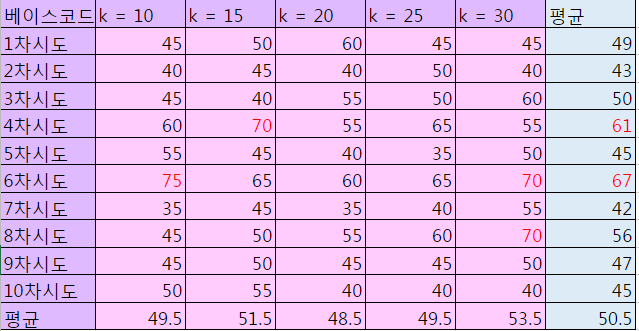

-> 결론적으로 베이스코드를 확인하였을 때 일반적으로 40~70%의 정확도를 보여준다.

- 다른 평가지표로도 확인할 필요가 있음!

# 3. 퍼스널 컬러 분류: Skin Detection + KNN

- 2번 베이스코드와 겹치는 함수는 생략함
- 원래 Skin Detection은 라벨링을 위한 작업으로만 하려고 했었는데 막상 모델과 붙여서 사용해보니 제일 성능이 좋았다...

## (1) Skin Detection 관련 함수

In [ ]:
def Skin_Detection(img_path):

  #Open a simple image
  img=cv2.imread(img_path)

  #converting from gbr to YCbCr color space
  img_YCrCb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
  #skin color range for hsv color space
  YCrCb_mask = cv2.inRange(img_YCrCb, (0, 135, 85), (255,180,135))
  YCrCb_mask = cv2.morphologyEx(YCrCb_mask, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))

  YCrCb_result = cv2.bitwise_not(YCrCb_mask)
  YCrCb_skin_detected = cv2.bitwise_and(img, img, mask=YCrCb_mask)

  return img_YCrCb, YCrCb_mask

In [ ]:
# skin 좌표 추출, YCrCb 픽셀값 추출
def coordinate_extraction(mask, img):
  skin = np.argwhere(mask == 255) # mask의 픽셀값이 255인 skin부분의 좌표 추출

  pixel_values = [] # YCbCr 픽셀값 저장을 위한 리스트

  for index in skin:
    y, x = index  #일반적으로 생각하는 가로 x, 세로 y로 표현하기 위해 위치 바꿈
    #print(f"x: {x}, y: {y}") # skin 범위 좌표값 출력(스압주의)
    pixel_value = img[y, x]
    pixel_values.append(pixel_value)

  for coord, pixel_value in zip(skin, pixel_values): # skin부분의 좌표값과 픽셀값 출력을 위한 함수
    x, y = coord
    #print(f"Coordinate: ({x}, {y}), Pixel Value: {pixel_value}")

  return pixel_values

In [ ]:
# 픽셀의 평균값 구하기
def pixel_means(pixel_values):
  # 열 별로 원소들을 더하기
  column_sums = np.sum(pixel_values, axis=0)

  # pixel_values를 NumPy 배열로 변환
  pixel_values = np.array(pixel_values)

  # 열 별로 평균 계산하기
  column_means = column_sums / pixel_values.shape[0]

  return column_means

## (2) 데이터 불러오기 및 데이터 전처리

In [ ]:
def get_dict(dir_path):
  file_list = os.listdir(dir_path)

  img_list = []
  result_list = []

  for file in file_list:
    img_path = os.path.join(dir_path, file)
    if os.path.isdir(img_path):  # 만약 디렉토리인 경우, 무시하고 다음 파일로 넘어감
      continue
    img_YCrCb,YCrCb_mask = Skin_Detection(img_path)
    img_list.append([img_YCrCb, YCrCb_mask]) # 그림 show()를 위한 용도

    # YCrCb
    YCrCb_pixel_values = coordinate_extraction(YCrCb_mask, img_YCrCb)
    YCrCb_pixel_means = pixel_means(YCrCb_pixel_values)
    #print(YCrCb_pixel_means)

    result_list.append(YCrCb_pixel_means)

  # array로 변환
  result_array = np.array(result_list)

  return result_array

In [ ]:
path = "/content/drive/MyDrive/four_seasons/사계절_연예인 이미지 데이터셋/prototype/쿨톤_jpg"  # 디렉토리 경로
path2 = "/content/drive/MyDrive/four_seasons/사계절_연예인 이미지 데이터셋/prototype/웜톤_jpg"  # 디렉토리 경로

In [ ]:
cool_result  = get_dict(path) # 1분

In [ ]:
warm_result  = get_dict(path2) # 1분

In [ ]:
images = np.concatenate((cool_result, warm_result), axis=0)

In [ ]:
# labels에 대한 코드
num = len(images)
labels = np.zeros(num)

# 처음 50개의 요소를 1로 변경
labels[length:] = 1

# 0이 쿨톤 1이 웜톤
print(len(images))
print(labels)

100
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]


## (3) train, validation, test 데이터 분리하기

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(images,
                                                  labels,
                                                  test_size=0.3,
                                                  random_state=42)

print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

x_train:  (70, 3)
y_train:  (70,)
x_val:  (30, 3)
y_val:  (30,)


## (4) KNN 실행하기

In [ ]:
# 검증 셋에서 가장 잘 동작하는 hyperparameter 들을 찾는다.
validation_accuracies = []
for k in range(1, 31):

    # 특정 k 값을 정해서 검증 데이터에 대해 평가할 때 사용한다.
    nn = NearestNeighbor()
    nn.train(x_train, y_train)
    # 여기서는 k를 input으로 받을 수 있도록 변형된 NearestNeighbor 클래스가 있다고 가정하자.
    Yval_predict = nn.predict(x_val, k = k)
    acc = np.mean(Yval_predict == y_val)
    print('k = %d, ' % (k), 'accuracy: %f' % (acc,))

    # 검증 셋에 대한 정확도를 저장해 놓는다.
    validation_accuracies.append((k, acc))

k = 1,  accuracy: 0.566667
k = 2,  accuracy: 0.633333
k = 3,  accuracy: 0.566667
k = 4,  accuracy: 0.600000
k = 5,  accuracy: 0.566667
k = 6,  accuracy: 0.566667
k = 7,  accuracy: 0.566667
k = 8,  accuracy: 0.566667
k = 9,  accuracy: 0.566667
k = 10,  accuracy: 0.533333
k = 11,  accuracy: 0.533333
k = 12,  accuracy: 0.600000
k = 13,  accuracy: 0.566667
k = 14,  accuracy: 0.600000
k = 15,  accuracy: 0.600000
k = 16,  accuracy: 0.566667
k = 17,  accuracy: 0.566667
k = 18,  accuracy: 0.533333
k = 19,  accuracy: 0.500000
k = 20,  accuracy: 0.533333
k = 21,  accuracy: 0.533333
k = 22,  accuracy: 0.566667
k = 23,  accuracy: 0.533333
k = 24,  accuracy: 0.533333
k = 25,  accuracy: 0.566667
k = 26,  accuracy: 0.566667
k = 27,  accuracy: 0.566667
k = 28,  accuracy: 0.500000
k = 29,  accuracy: 0.566667
k = 30,  accuracy: 0.566667


## (5) 평가하기

In [ ]:
# test에 적용할 가장 accuracy가 높은 값과 해당 인덱스 확인하기
max_value = max(validation_accuracies, key=lambda x: x[1])[1]
max_index = max(validation_accuracies, key=lambda x: x[1])[0]

print("두 번째 요소에서 가장 큰 값:", max_value)
print("두 번째 요소에서 가장 큰 값의 인덱스:", max_index) #k

두 번째 요소에서 가장 큰 값: 0.6333333333333333
두 번째 요소에서 가장 큰 값의 인덱스: 2


In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = nn.predict(x_val, max_index)
cm = confusion_matrix(y_val, y_pred)
print(cm)

[[11  6]
 [ 5  8]]


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         0.0       0.69      0.65      0.67        17
         1.0       0.57      0.62      0.59        13

    accuracy                           0.63        30
   macro avg       0.63      0.63      0.63        30
weighted avg       0.64      0.63      0.63        30



## (6) 테스트하기

In [ ]:
# test 불러오기 (여러개 버전)
test_path = "/content/drive/MyDrive/four_seasons/사계절_연예인 이미지 데이터셋/prototype/연예인 사진 10장"
x_test = get_dict(test_path)

# test
Ytest_predict = nn.predict(x_test, k = max_index)
print("예측값: ", Ytest_predict)

예측값:  [0. 0. 1. 0. 0. 0. 0. 0. 0. 1.]


In [ ]:
# test 불러오기 (낱개 버전)
# 은 파업

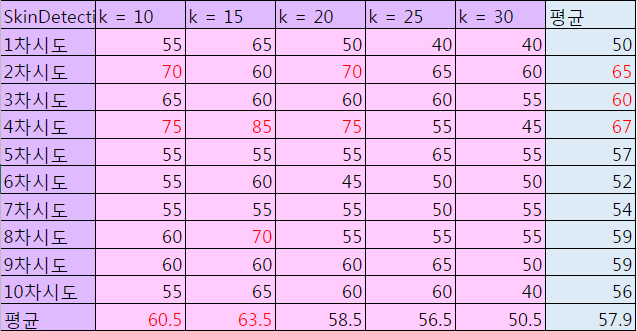  

-> 결론적으로 skin detection을 통하여 추출한 피부 픽셀들의 평균으로 확인하였을 때는 k가 15일 때 85%의 정확도까지 나왔으며 일반적으로 45%~85%사이의 값이 나온다.

# 4. 퍼스널 컬러 분류: Face_Recognition + KNN
- 이미 face_crop된 사진을 불러와서 이용
- 이 밑으로 정리 아직 안됨
---



## (1) 라이브러리 및 데이터 불러오기

In [2]:
import tensorflow as tf
import numpy as np
import cv2
import os
import glob
from PIL import Image

In [3]:
def load_images_from_directory(directory_path):
    image_paths = glob.glob(directory_path + '/*.jpg')  # 디렉토리 내의 모든 jpg 파일 경로 찾기
    image_paths.extend(glob.glob(directory_path + '/*.jpeg'))  # 디렉토리 내의 모든 jpeg 파일 경로 추가

    images = []
    for image_path in image_paths:
        image = Image.open(image_path)
        image_np = np.array(image)
        images.append(image_np)

    return images

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# 모든 이미지 불러오기
directory_path = "/content/drive/MyDrive/four_seasons/사계절_연예인 이미지 데이터셋/prototype/cropped_face/쿨톤"  # 디렉토리 경로
directory_path2 = "/content/drive/MyDrive/four_seasons/사계절_연예인 이미지 데이터셋/prototype/cropped_face/웜톤"  # 디렉토리 경로
images = load_images_from_directory(directory_path)
images2 = load_images_from_directory(directory_path2)

length = len(images)
print(length)
print(len(images2))

# 이미지 리스트 합치기
images = np.concatenate((images, images2), axis=0)
print(len(images))

50
50
100


<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


## (2) 데이터 전처리

In [6]:
# 리사이즈할 함수
def images_resize (images):
  # 새로운 크기로 리사이즈할 이미지의 너비와 높이
  new_width = 200
  new_height = 200

  resized_images = []
  for image in images:
    resized_image = cv2.resize(image, (new_width, new_height))
    resized_images.append(resized_image)

  # resized_images 리스트를 NumPy 배열로 변환
  resized_images_array = np.array(resized_images)

  # 변환된 NumPy 배열 출력
  print(resized_images_array.shape)

  return resized_images_array

resized_images_array = images_resize(images)

(100, 200, 200, 3)


In [7]:
# 평탄화 작업
images = resized_images_array.reshape(resized_images_array.shape[0], 200 * 200 * 3) /255

In [8]:
# labels에 대한 코드
num = len(images)
labels = np.zeros(num)

# 처음 50개의 요소를 1로 변경
# 0이 쿨톤 1이 웜톤
labels[length:] = 1

# 0이 쿨톤 1이 웜톤
print(len(images))
print(labels.shape)
print(labels)

100
(100,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]


## (3) train, validation, test 분리하기

In [9]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(images,
                                                  labels,
                                                  test_size=0.3,
                                                  random_state=42)

print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

x_train:  (70, 120000)
y_train:  (70,)
x_val:  (30, 120000)
y_val:  (30,)


## (4) KNN

In [10]:
class NearestNeighbor(object):
    def __init__(self):
        pass

    def train(self, X, y):
        """ X is N x D where each row is an example. Y is 1-dimension of size N """
        # nearest neighbor 분류기는 단순히 모든 학습 데이터를 기억해둔다.
        self.Xtr = X
        self.ytr = y

    def predict(self, X, k):
        """ X is N x D where each row is an example we wish to predict label for """
        num_test = X.shape[0]
        # 출력 type과 입력 type이 갖게 되도록 확인해준다.
        Ypred = np.zeros(num_test, dtype = self.ytr.dtype)

    # loop over all test rows
        for i in range(num_test):
        # i번째 테스트 이미지와 가장 가까운 학습 이미지를
            # L1 거리(절대값 차의 총합)를 이용하여 찾는다.
            #distances = np.sum(np.abs(self.Xtr - X[i,:]), axis = 1)
            # L2 거리(직선 거리)를 이용하여 찾는다.
            distances = np.sqrt(np.sum(np.square(self.Xtr - X[i,:]), axis = 1))

            indices = np.argsort(distances)  # 거리가 작은 순서대로 인덱스 정렬
            k_nearest_labels = self.ytr[indices[:k]]  # k개의 가장 가까운 이웃의 라벨
            unique, counts = np.unique(k_nearest_labels, return_counts=True)
            Ypred[i] = unique[np.argmax(counts)]  # 가장 많은 투표를 받은 라벨로 예측
        return Ypred

In [11]:
# 검증 셋에서 가장 잘 동작하는 hyperparameter 들을 찾는다.
validation_accuracies = []
for k in range(1, 31):

    # 특정 k 값을 정해서 검증 데이터에 대해 평가할 때 사용한다.
    nn = NearestNeighbor()
    nn.train(x_train, y_train)
    # 여기서는 k를 input으로 받을 수 있도록 변형된 NearestNeighbor 클래스가 있다고 가정하자.
    Yval_predict = nn.predict(x_val, k = k)
    acc = np.mean(Yval_predict == y_val)
    print('k = %d, ' % (k), 'accuracy: %f' % (acc,))

    # 검증 셋에 대한 정확도를 저장해 놓는다.
    validation_accuracies.append((k, acc))

k = 1,  accuracy: 0.400000
k = 2,  accuracy: 0.633333
k = 3,  accuracy: 0.433333
k = 4,  accuracy: 0.600000
k = 5,  accuracy: 0.466667
k = 6,  accuracy: 0.600000
k = 7,  accuracy: 0.600000
k = 8,  accuracy: 0.600000
k = 9,  accuracy: 0.500000
k = 10,  accuracy: 0.600000
k = 11,  accuracy: 0.533333
k = 12,  accuracy: 0.633333
k = 13,  accuracy: 0.666667
k = 14,  accuracy: 0.666667
k = 15,  accuracy: 0.633333
k = 16,  accuracy: 0.700000
k = 17,  accuracy: 0.700000
k = 18,  accuracy: 0.600000
k = 19,  accuracy: 0.700000
k = 20,  accuracy: 0.700000
k = 21,  accuracy: 0.700000
k = 22,  accuracy: 0.633333
k = 23,  accuracy: 0.633333
k = 24,  accuracy: 0.633333
k = 25,  accuracy: 0.566667
k = 26,  accuracy: 0.533333
k = 27,  accuracy: 0.566667
k = 28,  accuracy: 0.566667
k = 29,  accuracy: 0.600000
k = 30,  accuracy: 0.633333


## (5) 평가하기

In [12]:
# test에 적용할 가장 accuracy가 높은 값과 해당 인덱스 확인하기
max_value = max(validation_accuracies, key=lambda x: x[1])[1]
max_index = max(validation_accuracies, key=lambda x: x[1])[0]

print("두 번째 요소에서 가장 큰 값:", max_value)
print("두 번째 요소에서 가장 큰 값의 인덱스:", max_index) #k

두 번째 요소에서 가장 큰 값: 0.7
두 번째 요소에서 가장 큰 값의 인덱스: 16


In [13]:
from sklearn.metrics import confusion_matrix

y_pred = nn.predict(x_val, max_index)
cm = confusion_matrix(y_val, y_pred)
print(cm)

[[10  7]
 [ 2 11]]


In [14]:
from sklearn.metrics import classification_report

print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         0.0       0.83      0.59      0.69        17
         1.0       0.61      0.85      0.71        13

    accuracy                           0.70        30
   macro avg       0.72      0.72      0.70        30
weighted avg       0.74      0.70      0.70        30



## (6) 테스트하기

In [15]:
# test 불러오기 (여러개 버전)
test_path = "/content/drive/MyDrive/four_seasons/사계절_연예인 이미지 데이터셋/prototype/연예인 사진 10장"
test_images = load_images_from_directory(test_path)

# 이미지 리사이즈
x_test = images_resize(test_images)

# 평탄화 작업
x_test = x_test.reshape(x_test.shape[0], 200 * 200 * 3) /255
print(x_test.shape)

# test
Ytest_predict = nn.predict(x_test, k = max_index)
print("예측값: ", Ytest_predict)

(8, 200, 200, 3)
(8, 120000)
예측값:  [1. 1. 1. 1. 1. 1. 1. 1.]


In [16]:
# test 불러오기 (낱개 버전)
test_path = "/content/drive/MyDrive/four_seasons/사계절_연예인 이미지 데이터셋/prototype/연예인 사진 10장/01.jpg"
x_test = Image.open(test_path)
x_test = np.array(x_test)
print(x_test.shape)

# 배열의 크기 변환
x_test = x_test.reshape((1, x_test.shape[0], x_test.shape[1], 3))
print("변환된 배열 크기:", x_test.shape)

# 리사이즈
x_test = images_resize(x_test)

# 평탄화 작업
x_test = x_test.reshape(x_test.shape[0], 200 * 200 * 3) /255
print(x_test.shape)

# test
Ytest_predict = nn.predict(x_test, k = max_index)
print("예측값", Ytest_predict)

(600, 600, 3)
변환된 배열 크기: (1, 600, 600, 3)
(1, 200, 200, 3)
(1, 120000)
예측값 [1.]


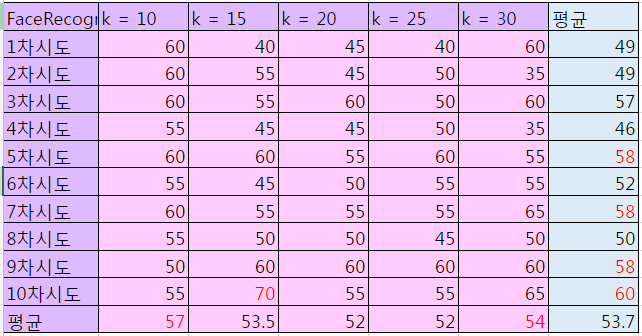


-> face_recognition을 이용하여 얼굴 영역만 추출한 사진으로 KNN을 실행하였을 때 최고로 10차 시도에서 70%까지 나왔으며 일반적으로 40%~65%정도 나온다.

# 5. Gradio에 KNN 결합하기
- 2. 베이스코드 실행 후에 실행한 gradio 결과임

In [1]:
!pip3 install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.8/19.8 MB 75.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.0/289.0 kB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 13.8 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of mdit-py-plugins to determine which version is compatible with other requirements. This could take a while.
  

In [48]:
class_names = ['쿨톤', '웜톤']

In [59]:
def classify_image(image):
  image = image.reshape((1, 200 * 200 * 3)) # shape 맞추기
  class_index = nn.predict(image, max_index) # 모델에 적용하기
  class_name = class_names[int(class_index[0])]
  return class_name

In [60]:
import gradio as gr

classification = gr.Interface(fn=classify_image,
                              inputs=gr.Image(shape=(200, 200)),
                              outputs = 'text'
                              )
classification.launch(share=True,
                      server_name = "0.0.0.0",
                      server_port = 8096)
                      # auth = ("noname", "passwdl"))

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://2e67b0bd51c72a2b05.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


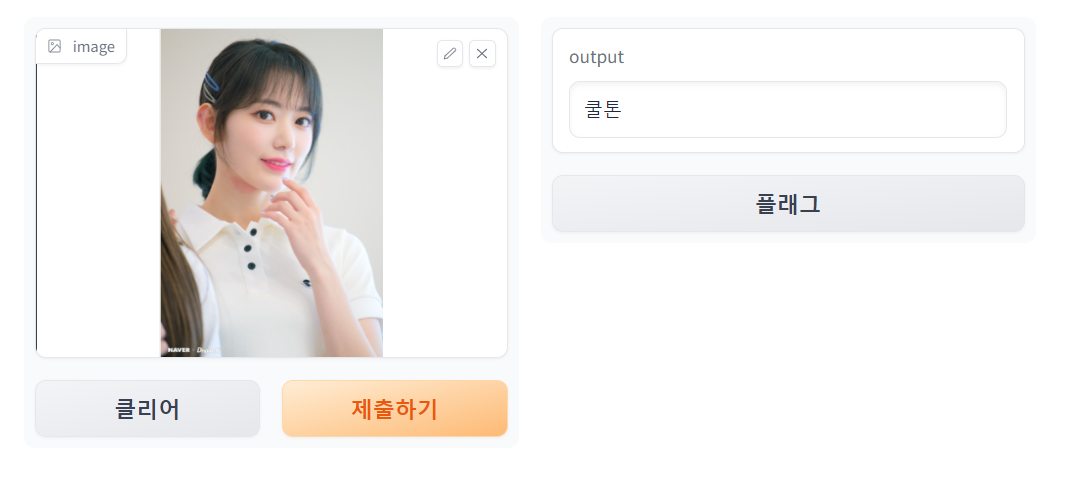